In [1]:
# Fill in your name using the format below and student ID number
your_name = "LAST_NAME, FIRST_NAME"
student_id = "YOUR_ID"

# Assignment 2
The [Speed Dating dataset](https://www.openml.org/d/40536) collects feedback gathered from participants in experimental speed dating events. Every participant rated themselves and their dates according to different attributes (e.g. attractiveness, sincerity, intelligence, fun, ambition, and shared interests,...), and whether or not they were interested in a second date. Our goal is to build a machine learning model able to predict whether there will be a match (or not) between two different people. Will you be able to trust your final model?

In [2]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
start_time = time.time()

### Additional packages:
* TargetEncoder
    - Run `pip install category_encoders` or `conda install -c conda-forge category_encoders`
* Seaborn (plotting)
    - Run `pip install seaborn` or `conda install seaborn`

In [3]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import category_encoders
import seaborn
sklearn_version = sklearn.__version__
catencoder_version = category_encoders.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(catencoder_version) < version.parse("2.0.0"):
    print("category_encoders is outdated. Please update now!")
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [4]:
# Download Speed Dating data. Takes a while the first time. Do not change this code!
# Note that X is a pandas dataframe 
dates = openml.datasets.get_dataset(40536)
X, y, _, feat_names = dates.get_data(target=dates.default_target_attribute)

In [5]:
# Cleanup. Do not change this code!
# Remove irrelevant or preprocessed columns 
cols = [c for c in X.columns if ((c.lower()[:2] != 'd_' or c.lower() == 'd_age') and c.lower() not in ['wave','has_null'])]
X = X[cols]
classes = ['No match','Match']

# Fix feature name typos
X = X.rename(columns={'ambtition_important': 'ambition_important',
                     'sinsere_o': 'sincere_o'})

# Harmonize the field names somewhat
X['field'] = X['field'].str.lower()
X = X.astype({'field': 'category'})

# Drop columns with more than 10% missing values
missing_counts = X.isnull().sum() * 100 / len(X)
d = {k:v for (k,v) in missing_counts.items() if v>10}
X.drop(d.keys(), axis=1, inplace=True)

# Solves an implementation issue with TargetEncoder
y=y.astype(int)

In [6]:
# THIS WILL BE HELPFUL
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

In [7]:
# Peek at the remaining data
X

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,...,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,guess_prob_liked,met
0,female,21.0,27.0,6.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.14,3.0,7.0,6.0,0.0
1,female,21.0,22.0,1.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.54,3.0,7.0,5.0,1.0
2,female,21.0,22.0,1.0,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.16,3.0,7.0,NaN,1.0
3,female,21.0,23.0,2.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.61,3.0,7.0,6.0,0.0
4,female,21.0,24.0,3.0,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,law,...,10.0,10.0,9.0,8.0,1.0,0.21,3.0,6.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,male,25.0,26.0,1.0,European/Caucasian-American,Latino/Hispanic American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.64,10.0,2.0,5.0,0.0
8374,male,25.0,24.0,1.0,European/Caucasian-American,Other,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.71,10.0,4.0,4.0,0.0
8375,male,25.0,29.0,4.0,European/Caucasian-American,Latino/Hispanic American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,-0.46,10.0,6.0,5.0,0.0
8376,male,25.0,22.0,3.0,European/Caucasian-American,Asian/Pacific Islander/Asian-American,0,1.0,1.0,climate dynamics,...,9.0,10.0,10.0,7.0,3.0,0.62,10.0,5.0,5.0,0.0


In [8]:
# Check the column data types and missing data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   gender                         8378 non-null   category
 1   age                            8283 non-null   float64 
 2   age_o                          8274 non-null   float64 
 3   d_age                          8378 non-null   float64 
 4   race                           8315 non-null   category
 5   race_o                         8305 non-null   category
 6   samerace                       8378 non-null   category
 7   importance_same_race           8299 non-null   float64 
 8   importance_same_religion       8299 non-null   float64 
 9   field                          8315 non-null   category
 10  pref_o_attractive              8289 non-null   float64 
 11  pref_o_sincere                 8289 non-null   float64 
 12  pref_o_intelligence            828

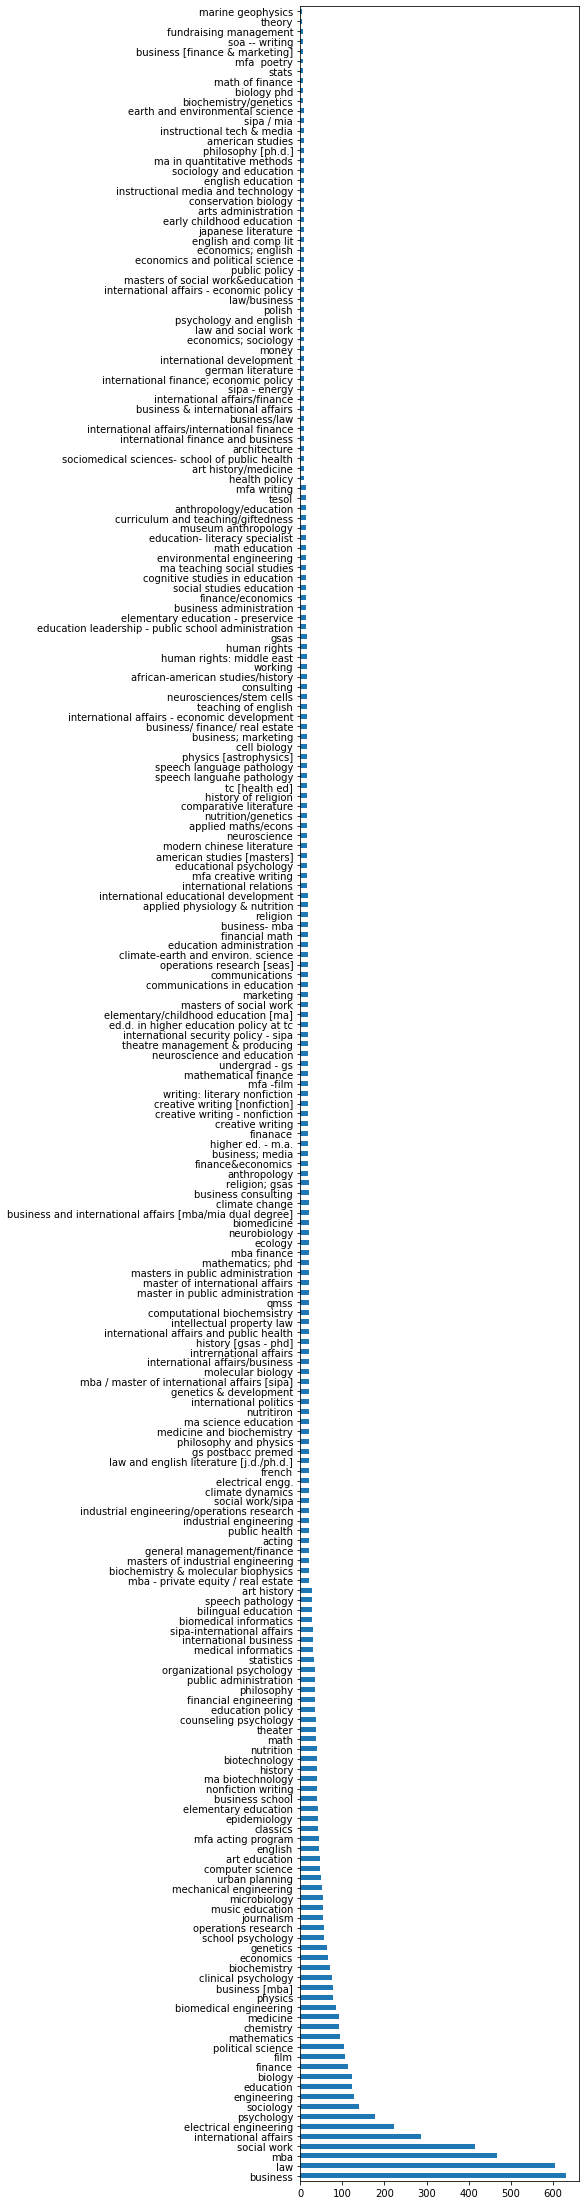

In [9]:
# Some categorical columns have a large number of possible values
# Note: It looks like some manual cleaning should be done, but let's move on
X['field'].value_counts().plot(kind='barh', figsize=(5,40));

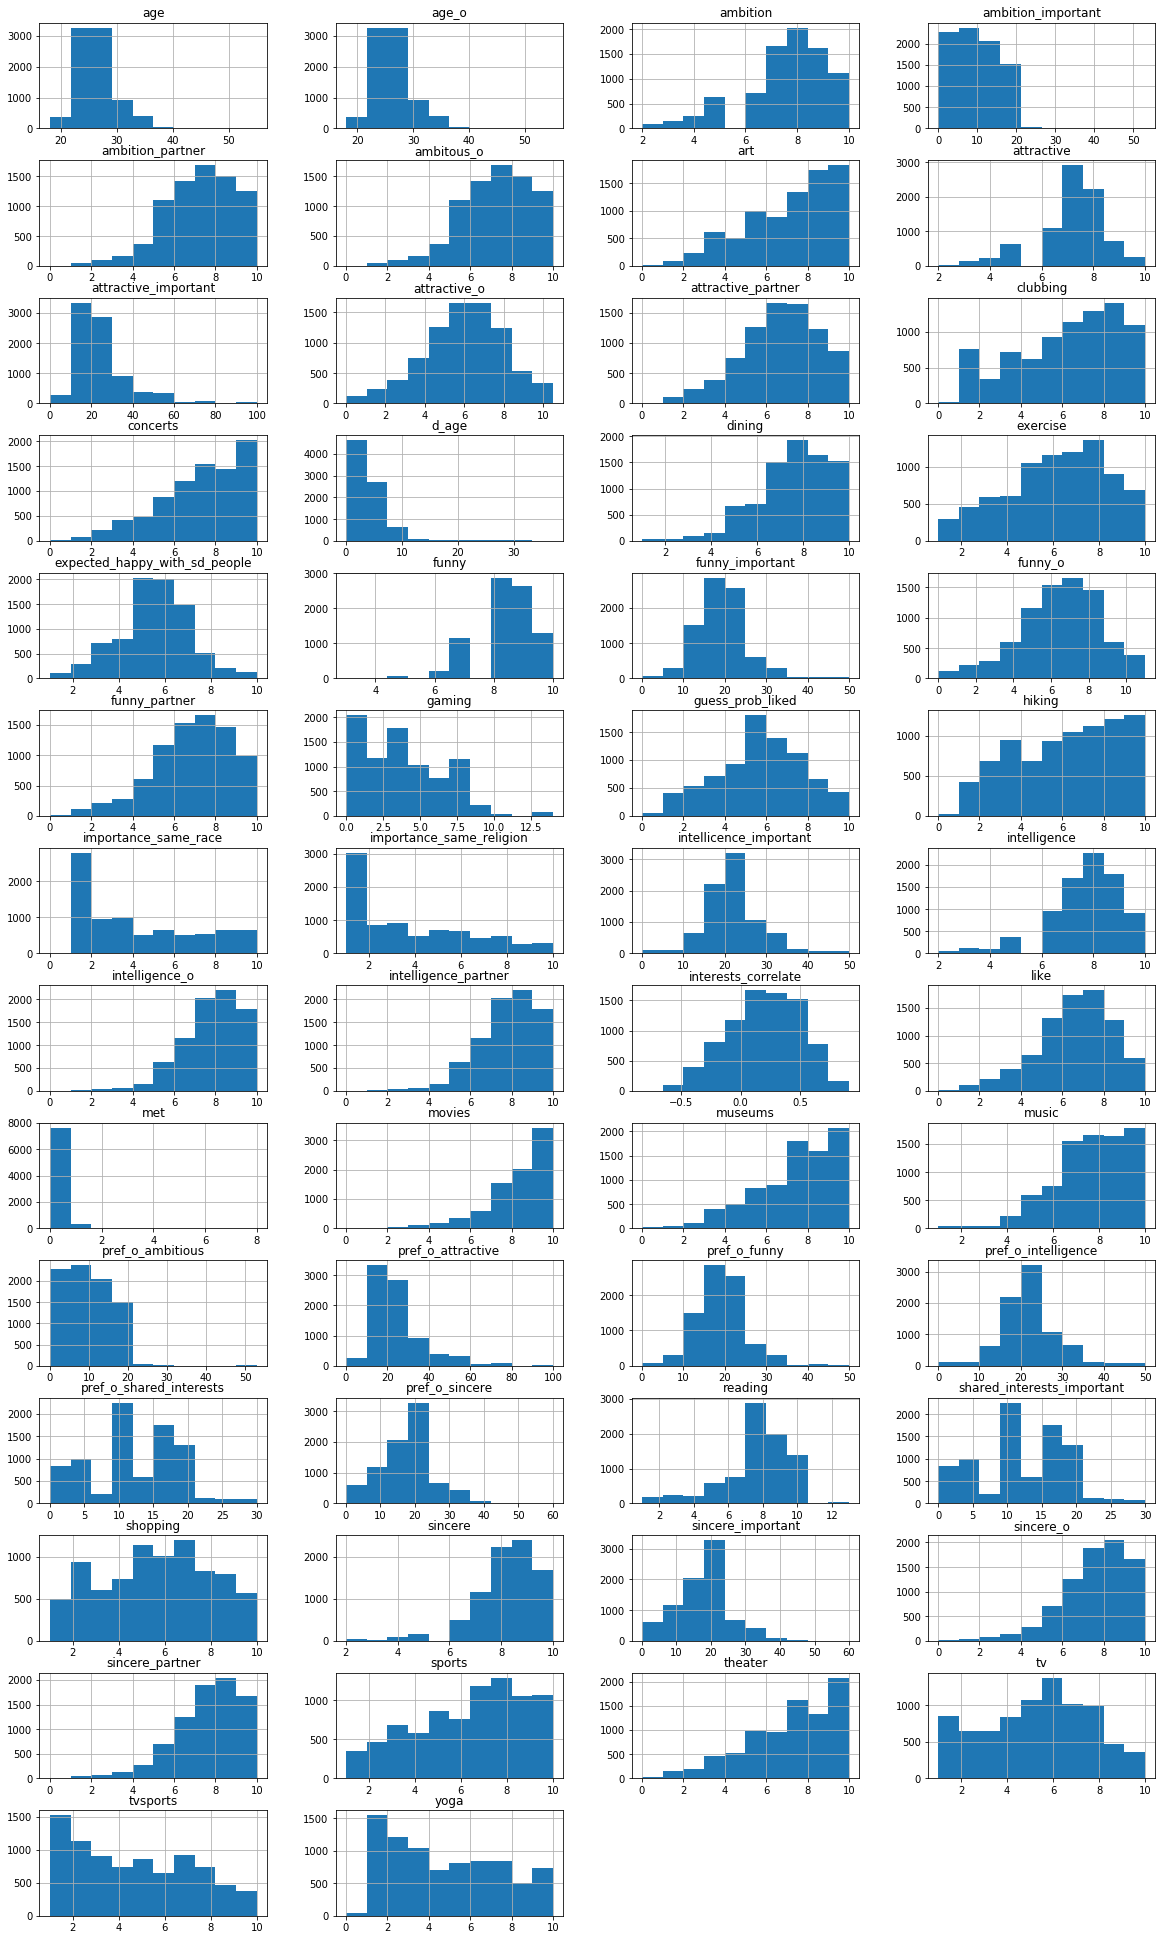

In [10]:
# Distributions of numeric data
X.hist(layout=(20,4), figsize=(20,50));

C:\Users\s141785\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


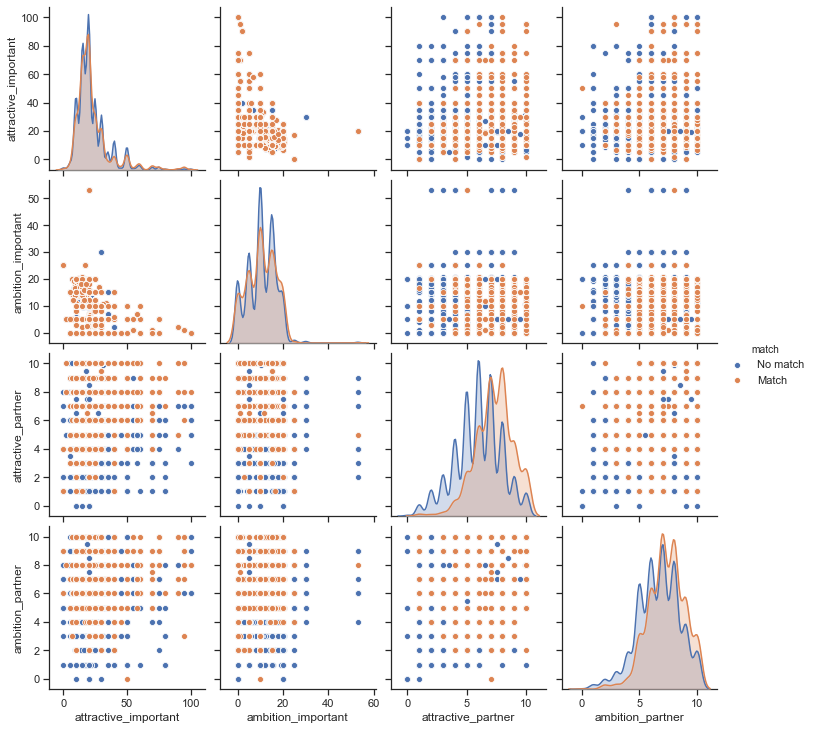

In [11]:
# What do people find important? Is this related to the outcome (match / no match)?
import seaborn as sns
subset = ['attractive_important','ambition_important','attractive_partner','ambition_partner']
X_sub=X[subset]
X_sub['match'] = [classes[int(x)] for x in y] 
sns.set(style="ticks")
sns.pairplot(X_sub, hue="match");

## Part 1: Preprocessing

### Question 1.1 (5 points)
Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a classifier:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature
    - Perform one-hot encoding. Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Remove missing values by replace missing values with the mean value for that feature

In [12]:
# Implement
def simple_pipeline(categorical, clf):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-encoding for categorical features
    Keyword arguments:
    categorical -- A list of categorical column names. Example: ['gender', 'country'].
    clf -- any scikit-learn classifier
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [13]:
### MODEL SOLUTION
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def simple_pipeline(categorical, clf):
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore'))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return make_pipeline(transform, clf)

#### Sanity check
To be correct, this pipeline should be able to fit any classifier without error. Run this code to do a sanity check.

In [14]:
from sklearn.tree import DecisionTreeClassifier
simple_pipeline(categorical, DecisionTreeClassifier()).fit(X,y);

### Question 1.2 (1 point)
How many features are being constructed by this pipeline (i.e. on how many features is the classifier trained)?

In [15]:
# Fill in the correct answer, should be an integer. Don't change the name of the variable
q_1_2 = 287

In [16]:
### MODEL SOLUTION
pipe = simple_pipeline(categorical, DecisionTreeClassifier()).fit(X,y)
print("There are {} features".format(np.shape(pipe.named_steps['columntransformer'].transform(X))[1]))

# Extra: breakdown per type
# One-hot-encoding constructs a new feature per possible category 
print("numeric:",len(numerical))
for f in categorical:
    print("{}: {}".format(f,len(X[f].value_counts())))

There are 287 features
numeric: 54
gender: 2
race: 5
race_o: 5
samerace: 2
field: 219


### Question 1.3 (3 points)
Implement a function `flexible_pipeline` that has two additional options:
- Allow to add a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling
- Allow the one-hot encoder to be replaced with another encoder, The default is one-hot encoding.

In [17]:
# Implement
from sklearn.preprocessing import StandardScaler
def flexible_pipeline(categorical, clf, scaler=StandardScaler(), encoder=OneHotEncoder()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    categorical -- A list of categorical column names. Example: ['gender', 'country'].
    clf -- any scikit-learn classifier
    scaler -- any scikit-learn feature scaling method (Optional)
    encoder -- any scikit-learn category encoding method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [18]:
### MODEL SOLUTION
def flexible_pipeline(categorical, clf, scaler=StandardScaler(), encoder=OneHotEncoder()):
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),encoder)
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),scaler)
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return make_pipeline(transform, clf)

### Question 1.4 (3 points)
Implement a function `plot_1_4` which plots a heatmap comparing several combinations of scaling methods and classifiers:
* As classifiers, the following algorithms in their default hyperparameters settings: 
    * Logistic regression
    * SVM with RBF kernel
    * Random Forest
* As options, the following feature scaling options in their default settings:
    * No scaling
    * Standard scaling
    * Normalize
    * PowerTransformer
* In all cases, use OneHotEncoder with `sparse=False` and `handle_unknown='ignore'`

You should evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

In [19]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

In [20]:
# Implement
def plot_1_4(X, y):
    """ Evaluates 3 classifiers together with 4 types of scaling. See description above.
    """
    pass

In [21]:
### MODEL SOLUTION
from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm

# Helper function to construct the score matrix
def heatmap_helper(X, y, classifiers, options, categorical, option='scaler'):
    o_names = [o.__class__.__name__ for o in options]
    c_names = [c.__class__.__name__ for c in classifiers]
    scores = []
    cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for o in tqdm(options, leave=False):
        o_scores = []
        for c in tqdm(classifiers, leave=False):
            if option == 'scaler':
                ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
                pipe = flexible_pipeline(categorical,c,scaler=o,encoder=ohe)
            elif option == 'encoder':
                pipe = flexible_pipeline(categorical,c,encoder=o)
            cv_scores = cross_validate(pipe, X, y, cv=cvs, n_jobs=-1, scoring='roc_auc')
            o_scores.append(np.mean(cv_scores['test_score']))
        scores.append(o_scores)
    heatmap(c_names, o_names, scores)

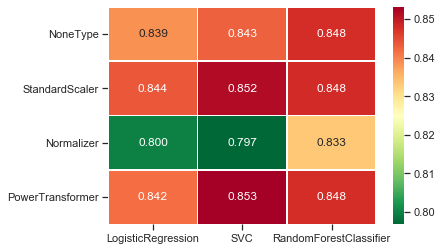

In [22]:
### MODEL SOLUTION
def plot_1_4(X, y):
    classifiers = [LogisticRegression(random_state=1),SVC(random_state=1),RandomForestClassifier(random_state=1)]
    options = [None, StandardScaler(), Normalizer(), PowerTransformer()]
    heatmap_helper(X, y, classifiers, options, categorical)

plot_1_4(X, y)

### Question 1.5 (1 point)
Interpret the heatmap of Question 1.4. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': All scaling methods perform equally well. It doesn't matter which scaling method is used.
- 'B': The best scaling method depends on the classifier that will be used.
- 'C': Scaling is important for SVMs and logistic regression, but not needed for Random Forests.
- 'D': The power transformer is much better than other techniques on this dataset because many features have a power law distribution.
- 'E': The Normalizer works badly because information gets lost in the scaling.
- 'F': No answer

In [23]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_1_5 = 'C'

**Explanation**  
- A: Clearly not, the Normalizer actually makes things worse
- B: Not really. The best scaling method seems to be the StandardScaler. The PowerTransformer is equally good for SVMs and RFs, ignoring tiny differences.
- C: Correct. For RFs not using scaling is as good as choosing the optimal scaler.
- D: No. On this dataset it is mostly on par with the StandardScaler.
- E: It doesn't really remove information, but it does not represent it in a useful way for this problem. It normalizes each sample to unit length. Hence, it does row-based normalization, not column-based normalization.

### Question 1.6 (3 points)
Optimize the encoding method for the categorical features. Use your `flexible_pipeline` to compare OneHotEncoding and TargetEncoding
together with the same 3 classifiers as in question 1.4. Always use standard scaling. Implement a function `plot_1_6` which plots a heatmap with the results.

TargetEncoding is part of the category encoders extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)

In [24]:
from category_encoders import TargetEncoder
# Implement
def plot_1_6(X, y):
    """ Evaluates 3 classifiers and plots the results in a bar chart.
    Also compares different category encoders
    """
    pass

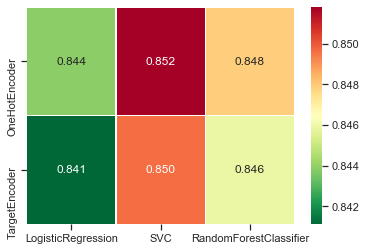

In [25]:
from category_encoders import TargetEncoder
def plot_1_6(X, y):
    classifiers = [LogisticRegression(random_state=1),SVC(random_state=1),RandomForestClassifier(random_state=1)]
    options = [OneHotEncoder(sparse=False, handle_unknown='ignore'), TargetEncoder()]
    heatmap_helper(X, y, classifiers, options, categorical, option='encoder')
plot_1_6(X, y)

### Question 1.7 (1 point)
Interpret the heatmap of Question 1.6. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': They perform equally well
- 'B': Target encoding is slightly better
- 'C': One-hot-encoding is slightly better
- 'D': It depends on the algorithm.
- 'E': No answer

In [26]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_1_7 = 'C'

**Explanation**  
Simple one-hot-encoding is slightly better. Most categorical features have low cardinality (low number of categories), hence one-hot-encoder will retain all information without increasing the dimensionality of the data too much. The only exception is the 'field' variable, which has many categories. Target encoding would probably help if it was an important feature. The fact that it doesn't probably means that the 'field' of work of a person is not very important to predict the match. On the other hand, target encoding always looses some information, which may explain why it works slightly less well.

### Question 1.8 (1 point)
How many features are being constructed by the target encoder pipeline (i.e. on how many features is the classifier trained)?

In [27]:
# Fill in the correct answer, should be an integer. Don't change the name of the variable
q_1_8 = 59

In [28]:
### MODEL SOLUTION
pipe = flexible_pipeline(categorical,DecisionTreeClassifier(),encoder=TargetEncoder()).fit(X,y)
print("There are {} features".format(np.shape(pipe.named_steps['columntransformer'].transform(X))[1]))

# Extra: breakdown per type
# Target encoding replaces each category with the prior probability that that category predicts the positive class 
print("numerical:",len(numerical))
print("categorical:",len(categorical))

There are 59 features
numerical: 54
categorical: 5


## Part 2: Feature importance
In this part, we will continue with your `flexible_pipeline`, and we use a random forest to learn which features
are most important to predict the outcome of a dating 'match'. We will do this with both Random Forest's importance estimates and with permutation importance.

### Question 2.1 (5 points)
Implement a function `plot_2_1` that does the following:  
* Split the data using a standard stratified and shuffled train-test split. Use `random_state=1`.
* Combine your `flexible_pipeline`, without feature scaling but with one-hot-encoding, with a RandomForest classifier. Train that pipeline on the training set.
* Remember that the categorical features where encoded. Retrieve their encoded names from the one-hot-encoder (with `get_feature_names`).
* Retrieve the feature importances from the trained random forest and match them to the correct names. Depending on how you implemented your `flexible_pipeline` these are likely the first or the last columns in the processed dataset.
* Compute the permutation importances given the random forest pipeline and the test set. Use `random_state=1` and at least 10 iterations.
* Pass the tree-based and permutation importances to the plotting function `compare_importances` below.

In [29]:
# Plotting function. Do not edit.
def compare_importances(rf_importance, perm_importance, rf_feature_names, feature_names):
    """ Compares the feature importances from random forest to permutation importance
    Keyword arguments:
    rf_importance -- The random forest's feature_importances_
    perm_importance -- The permutation importances as computed by sklearn.inspection.permutation_importance
    rf_feature_names -- The names of the features received by the random forest, in the same order as their importances
    feature_names -- The original features names in their original order
    """
    topk = 30
    # Trees
    sorted_idx = rf_importance.argsort()[-topk:]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    y_ticks = np.arange(0, topk)
    ax[0].barh(y_ticks, rf_importance[sorted_idx])
    ax[0].set_yticklabels(rf_feature_names[sorted_idx])
    ax[0].set_yticks(y_ticks)
    ax[0].set_title("Random Forest Feature Importances")

    # Permutations
    sorted_idx = perm_importance.importances_mean.argsort()[-topk:]
    ax[1].boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
    ax[1].set_title("Permutation Importances (test set)")

    fig.tight_layout()
    plt.show()

In [30]:
# Implement
def plot_2_1(X, y):
    """ See detailed description above.
    """
    pass

In [31]:
# MODEL IMPLEMENTATION
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Helper function. Allows to switch encoders.
def compare(X, y, encoder):
    # Train RF
    y=y.astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=1)
    rf_pipe = flexible_pipeline(categorical, RandomForestClassifier(), scaler=None, encoder=encoder)
    rf_pipe.fit(X_train, y_train)

    # Match feature names
    encoder_name = encoder.__class__.__name__.lower()
    enc = rf_pipe.named_steps['columntransformer'].named_transformers_['pipeline'].named_steps[encoder_name]
    feature_names = []
    if encoder_name == 'onehotencoder':
        feature_names = enc.get_feature_names(input_features=categorical)
    else:
        feature_names = [categorical[i] for i in enc.get_feature_names()]
    feature_names = np.r_[feature_names, numerical]

    # Get importances
    tree_feature_importances = rf_pipe.named_steps['randomforestclassifier'].feature_importances_
    permutation_importances = permutation_importance(rf_pipe, X_test, y_test, n_repeats=20,
                                        random_state=1, n_jobs=-1)
    test_feature_names = X_test.columns

    # Plot
    compare_importances(tree_feature_importances, permutation_importances, feature_names, test_feature_names)

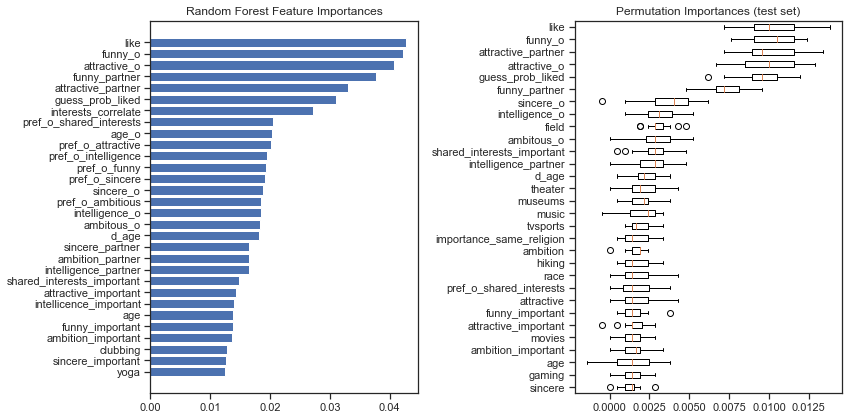

In [32]:
# MODEL IMPLEMENTATION
def plot_2_1(X,y):
    compare(X,y,OneHotEncoder(sparse=False, handle_unknown='ignore'))
plot_2_1(X,y)   

### Question 2.2 (1 point)
Interpret the results of Question 2.1. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': The topmost feature importances are roughly the same for both methods
- 'B': The topmost feature importances are very different
- 'C': Categorical features (race, race_o, field,...) are ranked higher in the random forest ranking
- 'D': Categorical features are ranked lower in the random forest ranking
- 'E': No answer

In [33]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_2_2 = 'A,D'

**Explanation**  
- A: Indeed. Being likable, attractive, and funny are important according to both methods. Intelligence and sincerity also generally rank high.
- B: No, see A.
- C: No, they do not even show up in the top RF-based feature importances. They are ranked higher according to permutation importance.
- D: Yes, see C.

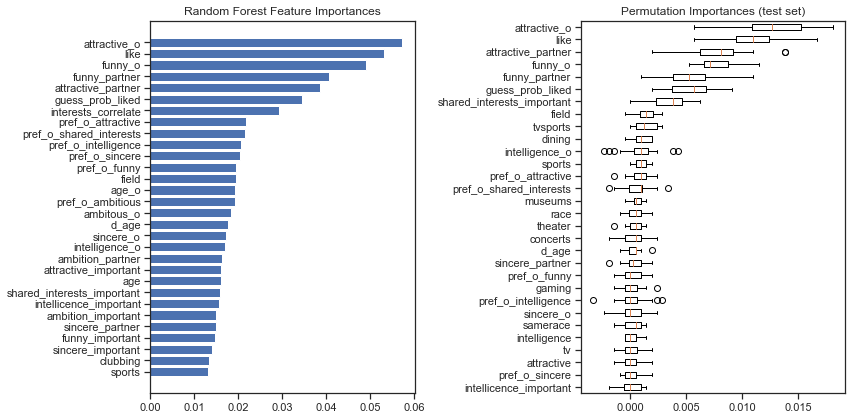

In [34]:
# MODEL IMPLEMENTATION - Extra
# Using target encoding instead of one-hot encoding makes the categorical features appear
# in the random forest feature ranking.
def plot_2_1b(X,y):
    compare(X,y,TargetEncoder(handle_unknown=0))
plot_2_1b(X,y)

Using TargetEncoding, 'field' becomes moderately important according to the random forest based rankings.

## Part 3: Calibrating predictions
### Question 3.1 (2 points)
Use a grid search to optimize the RandomForest pipeline from question 2.1. Vary the number of trees from 100 to 1500 and `max_features` from
0.05 to 0.1. Use at least 2 values for every hyperparameter. Evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Plot the results in a heatmap in function `plot_3_1`.

In [35]:
#Implement
def plot_3_1(X, y):
    """ See detailed description above.
    """
    pass

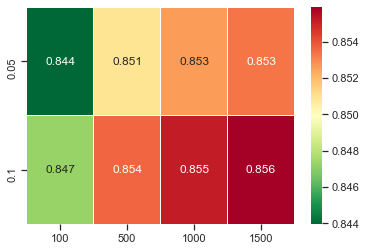

In [36]:
# MODEL IMPLEMENTATION
from sklearn.model_selection import GridSearchCV
def plot_3_1(X, y):
    param_grid = {'randomforestclassifier__n_estimators': [100, 500, 1000, 1500],
                  'randomforestclassifier__max_features': [0.05, 0.1]}
    pipe = flexible_pipeline(categorical, RandomForestClassifier(), scaler=None, encoder=OneHotEncoder(sparse=False, handle_unknown='ignore'))
    cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cvs, scoring='roc_auc', n_jobs=-1).fit(X, y)
    scores = grid.cv_results_['mean_test_score'].reshape(2, -1)
    heatmap(param_grid['randomforestclassifier__n_estimators'], param_grid['randomforestclassifier__max_features'],scores)
plot_3_1(X, y)

### Question 3.2 (2 points)
Implement a function `plot_3_2` that plots the ROC curve for the Random Forest pipeline with `n_estimators=1000`.
Also indicate the point on the curve that corresponds to the 0.5 probability decision threshold.

In [37]:
#Implement
def plot_3_2(X, y):
    """ See detailed description above.
    """
    pass

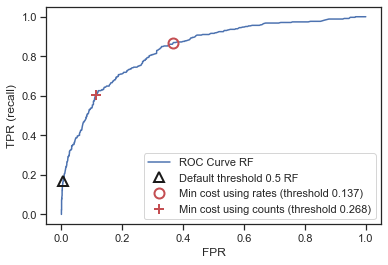

In [47]:
### MODEL SOLUTION
from sklearn.metrics import roc_curve
def build_ROC(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    pipe = flexible_pipeline(categorical, RandomForestClassifier(n_estimators=1000, random_state=1), scaler=None, 
                         encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')).fit(X_train,y_train)
    return roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

def plot_3_2(X, y):
    fpr_rf, tpr_rf, thresholds_rf = build_ROC(X, y)

    plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
    plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
             label="Default threshold 0.5 RF", fillstyle="none", c='k', mew=2)
    min_cost = np.argmin(np.abs(thresholds_rf - 0.137)) #see next question
    min_cost2 = np.argmin(np.abs(thresholds_rf - 0.268)) #see next question
    plt.plot(fpr_rf[min_cost], tpr_rf[min_cost], 'o', markersize=10, label="Min cost using rates (threshold 0.137)", fillstyle="none", c='r', mew=2)
    plt.plot(fpr_rf[min_cost2], tpr_rf[min_cost2], '+', markersize=10, label="Min cost using counts (threshold 0.268)", fillstyle="none", c='r', mew=2)
    plt.legend(loc=4)
plot_3_2(X, y)

### Question 3.3 (2 points)
Calibrate your model to get a higher recall. What would be the optimal decision threshold (approximately) assuming that a false negative (missing a good match) is twice as bad as a false positive (going on a date with someone who is not a good match)? The grade will depend on the distance to the actual optimum (within a tolerance).

In [44]:
# Fill in the correct answer, should be a float. Don't change the name of the variable
q_3_3 = 0.137

# Your results can be slightly different, but should be in the range [0.13-0.16]
# There is a second solution (see below) which yields an optimal threshold around 0.25 - 0.29.

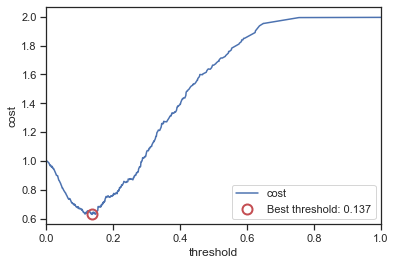

In [45]:
### MODEL SOLUTION
# Cost = cost_FP * FPR + cost_FN * (1-TPR)
def cost(fpr, tpr, cost_FN, cost_FP):
    return fpr * cost_FP + (1 - tpr) * cost_FN;

# compute
fpr, tpr, thresholds = build_ROC(X, y)
costs = [cost(fpr[x],tpr[x],2,1) for x in range(len(thresholds))]
min_cost = np.argmin(costs)

# plot
fig = plt.figure()
ax = fig.add_subplot(111, xlabel="threshold", ylabel="cost", xlim=(0,1))
ax.plot(thresholds, costs, label='cost')
ax.plot(thresholds[min_cost], costs[min_cost], 'o', markersize=10, 
        label="Best threshold: {}".format(thresholds[min_cost]), fillstyle="none", c='r', mew=2)
ax.legend(loc=4);

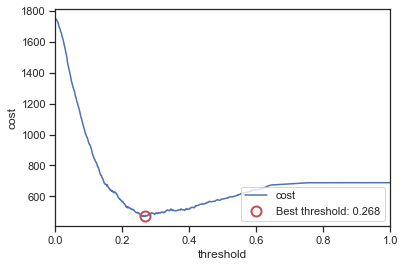

In [46]:
# Alternative: use the actual amount of FP, FN. This is also a feasible measure,
# although the cost then depends on the size of your test set.
# Because this was not specified in the question, both answers are deemed correct
from sklearn.metrics import confusion_matrix

# Cost = cost_FP * FP + cost_FN * FN
def cost2(fp, fn, cost_FN, cost_FP):
    return fp * cost_FP + fn * cost_FN;

# compute
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
pipe = flexible_pipeline(categorical, RandomForestClassifier(n_estimators=1000, random_state=1), scaler=None, 
                         encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')).fit(X_train,y_train)
proba = pipe.predict_proba(X_test)[:, 1]
# fp and fn can be retrieved from the confusion matrix (or by comparing to the true values ourselves)
# the prediction is true if the probability is above the threshold
fp = [confusion_matrix(y_test,(proba >= t)).ravel()[1] for t in thresholds]
fn = [confusion_matrix(y_test,(proba >= t)).ravel()[2] for t in thresholds]

costs = [cost2(fp[x],fn[x],2,1) for x in range(len(thresholds))]
min_cost = np.argmin(costs)

# plot
fig = plt.figure()
ax = fig.add_subplot(111, xlabel="threshold", ylabel="cost", xlim=(0,1))
ax.plot(thresholds, costs, label='cost')
ax.plot(thresholds[min_cost], costs[min_cost], 'o', markersize=10, 
        label="Best threshold: {}".format(thresholds[min_cost]), fillstyle="none", c='r', mew=2)
ax.legend(loc=4);

The optimal threshold is now a bit higher. Given the high class imbalance, the rates (FPR,FNR) and counts (FP,FN) 
can be quite different.

In [42]:
print(time.time()-start_time)

383.8051977157593
